In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init

In [31]:
# this is to make sure that the mibi top level package is in the python path
import sys
sys.path.append("..")
from mibi.preprocess.mibi_image import *
from mibi.preprocess.mibi_plot import *

In [4]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

In [5]:
data_dir = '/Users/mschachter/data/CHOP_TMA_pilot'
images_dir = os.path.join(data_dir, 'extracted')
channels_data_path = os.path.join(data_dir, 'info', 'channels.csv')

mp_images = dict()
for pdir in glob.glob(os.path.join(images_dir, 'Point*')):
    _,pname = os.path.split(pdir)
    print(f"Loading from {pdir}")
    mp_images[pname] = MIBIMultiplexImage.load_from_path(os.path.join(pdir, 'TIFs'), channels_data_path)

Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point4
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point3
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point5
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point11
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point16
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point20
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point18
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point26
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point19
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point21
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point17
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point10
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point7
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted/Point9
Loading from /Users/mschachter/data/CHO

In [6]:
mp_img = mp_images['Point21']
gold_chan_idx = mp_img.label_to_index['197_Au']
img = mp_img.X[gold_chan_idx]
img.shape

(1024, 1024)

In [54]:
X = torch.tensor(mp_img.X)
X.shape

torch.Size([23, 1024, 1024])

In [55]:
from torch.nn import Fold, Unfold

class PatchMaker(object):
    
    def __init__(self, image_size=(1024, 1024), kernel_size=256, stride=64):
        self.image_size = image_size
        self.unfold_params = {"kernel_size":kernel_size, "stride":stride}
        self.fold_params =  {"kernel_size":kernel_size, "stride":stride, "output_size":image_size}
        
        self.unfold_layer = Unfold(**self.unfold_params)
        self.fold_layer = Fold(**self.fold_params)
        
    def patch(self, X):
        """ Create a patchified tensor from X. X must be shape (nbatch, nchannels, height, width). """
        assert len(X.shape) == 4
        X_patch_flat = unfold_layer(X)
        X_patch = timg_patch_flat.reshape([1, timg.shape[0],
                                           self.unfold_params['kernel_size'],
                                           self.unfold_params['kernel_size'],
                                           -1])
        return X_patch
    
    def unpatch(self, X):
        """ Unpatch a tensor X. X must be shape (nbatch, nchannels, height, width, npatches). """
        assert len(X.shape) == 5
        nbatch, nchans, h, w, npatch = X.shape
        X_patch_flat = X.reshape([nbatch, nchans*h*w, npatch])
        X_unpatch = self.fold_layer(X_patch_flat)
        
        return X_unpatch

pm = PatchMaker()
X_patch = pm.patch(X.unsqueeze(0))
X_patch.shape

torch.Size([1, 23, 256, 256, 169])

In [56]:
X_unpatch = pm.unpatch(X_patch)
X_unpatch.shape

torch.Size([1, 23, 1024, 1024])

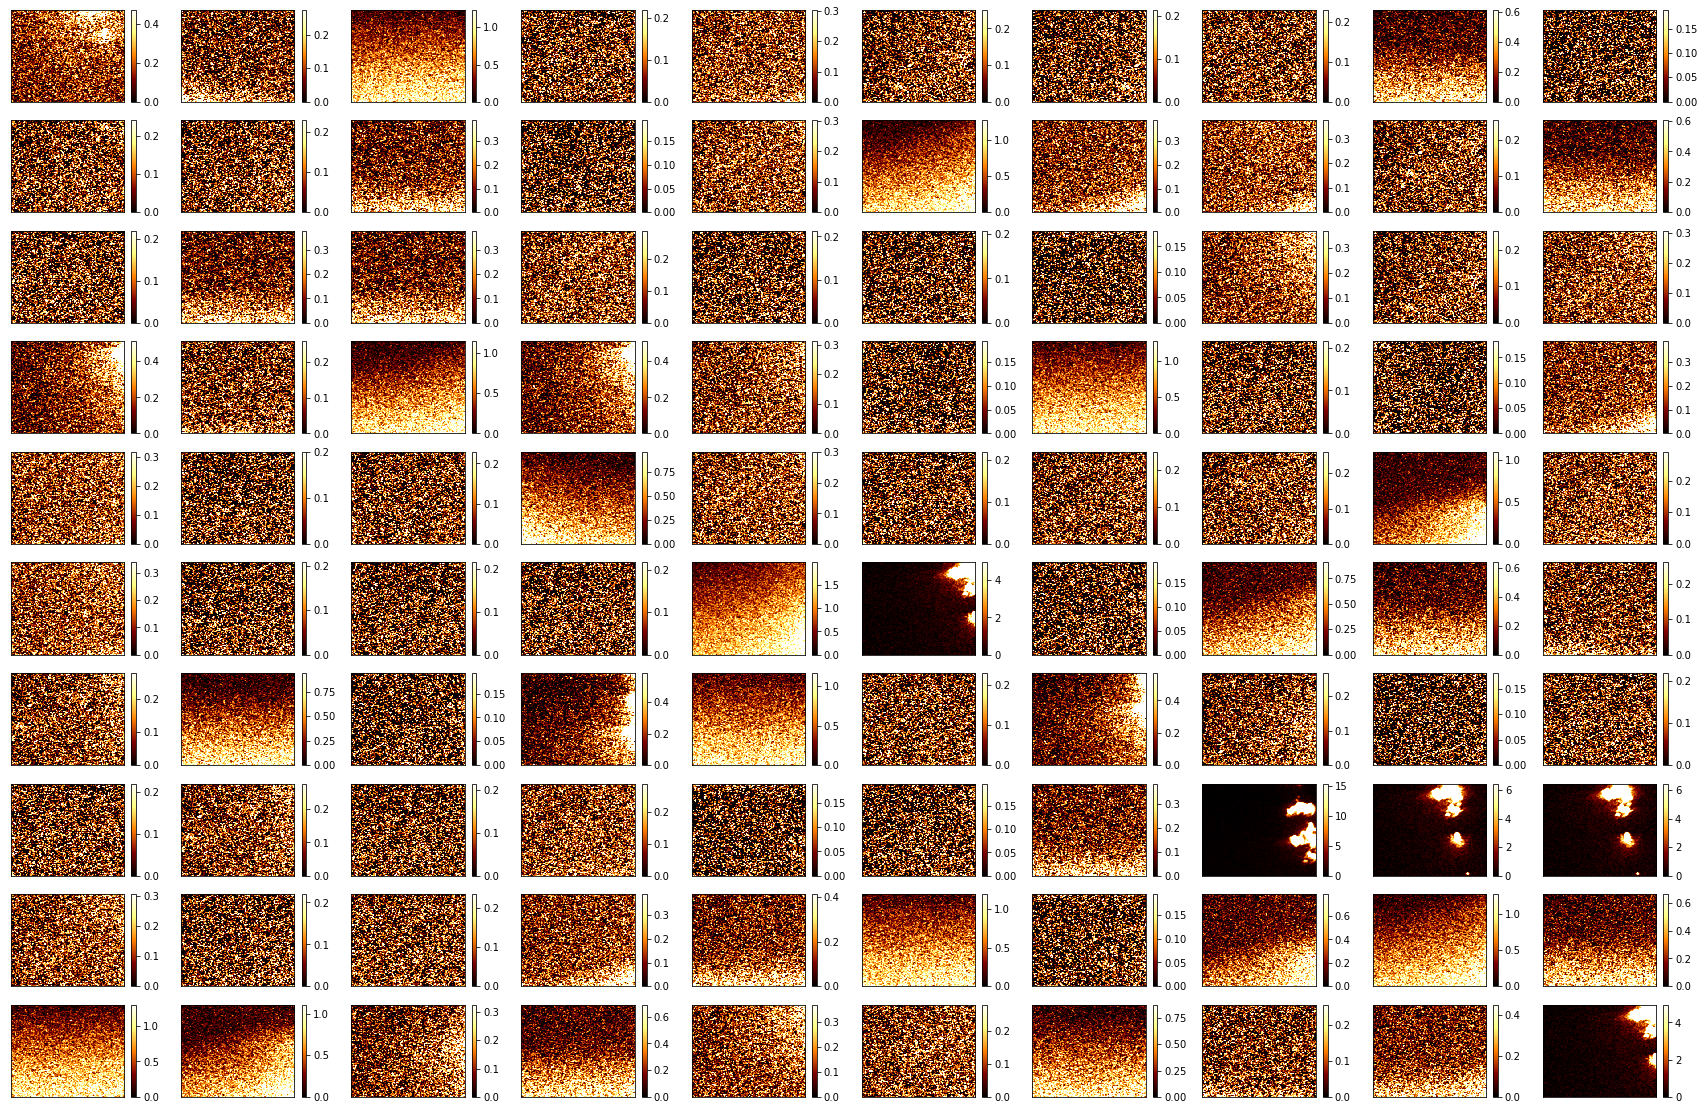

In [53]:
nrows = 10
ncols = 10
figsize = (nrows*3, ncols*2)

chan_idx = gold_chan_idx

fig = plt.figure(figsize=figsize)
patch_indices = np.random.choice(np.arange(timg_patch.shape[-1]), size=nrows*ncols)
for sp,idx in enumerate(patch_indices):
    ax = plt.subplot(nrows, ncols, sp+1)
    plot_img(X_patch[0, chan_idx, :, :, idx].squeeze().numpy(), transform=False)

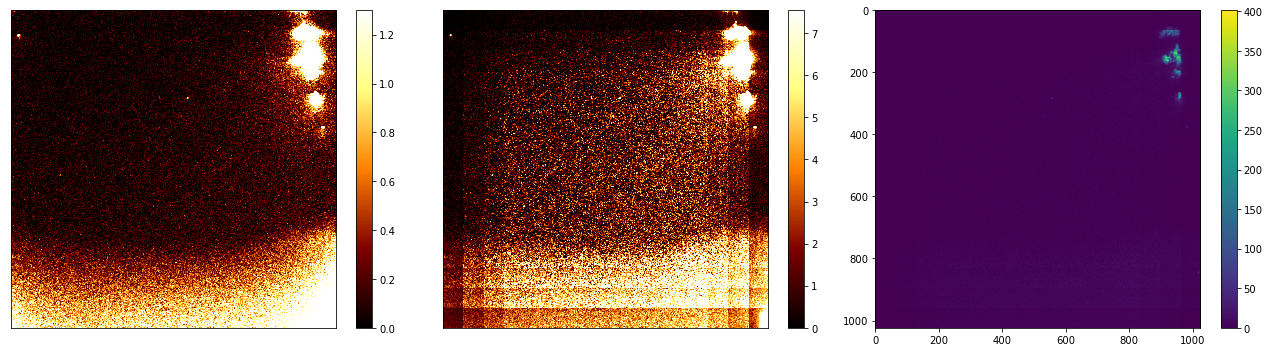

In [68]:
img1 = X[gold_chan_idx, :, :].numpy()
img2 = X_unpatch[0, gold_chan_idx, :, :].squeeze().numpy()
img_diff = img2 - img1

fig = plt.figure(figsize=(18, 5))
nrows = 1
ncols = 3

ax = plt.subplot(nrows, ncols, 1)
plot_img(img1, transform=False)

ax = plt.subplot(nrows, ncols, 2)
plot_img(img2, transform=False)

ax = plt.subplot(nrows, ncols, 3)
plt.imshow(img_diff, interpolation='nearest', aspect='auto', cmap=plt.cm.viridis)
plt.colorbar();

plt.tight_layout()

In [ ]:
sz = 256
olap = 64
#timg.unfold(1, sz, olap).unfold(2, sz, olap).shape

In [ ]:
#timg.unfold(1, sz, olap).unfold(2, sz, olap).reshape([23, 256, 256]).shape

# TODO: CCA within FOVs to see shared components - are they tissue, gold, something else?